# Fit BAO peak from input correlation function

In [1]:
import os
import tempfile
import time
import copy

import numpy as np
import scipy

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from cosmoprimo import *

import catalog_data
import density_split
from density_split_mocks_functions import split_density, compute_densitySplit_CCF
from pk_model import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
catalog_name = 'AbacusSummit_1Gpc_z1.175'
bias = 1.8

#catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()

bg = cosmo_abacus.get_background()

f = bg.Omega_m(z)**0.55

### Load correlation function poles

In [5]:
ells = [0]
nells = len(ells)
nsplits = 2

In [6]:
s, xiell_split, cov_split = np.load(output_dir+catalog.name+'_1000_mocks_densitySplit_gg_CCF_monopole_cov.npy', allow_pickle=True)
std_split = np.array_split(np.array(np.array_split(np.diag(cov_split)**0.5, nells)), nsplits, axis=1)

In [7]:
def extract_subcovmatrix(s, cov, ells, nsplits, split_extract):
    ns = len(s)
    
    nells = len(ells)
    
    cov_extract = cov[split_extract*nells*ns:(split_extract+1)*nells*ns, 
                      split_extract*nells*ns:(split_extract+1)*nells*ns]
    
    return cov_extract

In [8]:
split = 1

xiell = xiell_split[split]
cov = extract_subcovmatrix(s, cov_split, ells, nsplits, split_extract=split)
std = np.array_split(np.diag(cov)**0.5, nells)

## Plot multipoles

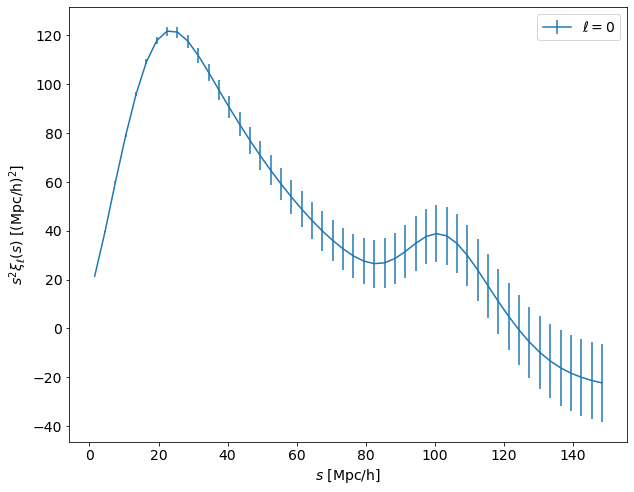

In [9]:
for ill,ell in enumerate(ells):
    plt.errorbar(s+ill*0.1, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='$\ell = {:d}$'.format(ell))
plt.legend()
plt.xlabel(r'$s$ [Mpc/h]')
plt.ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/$h$)^{2}$]')
#plt.ylim(-0.2, 1)
plt.show()

## Generate power spectrum used in the model to fit

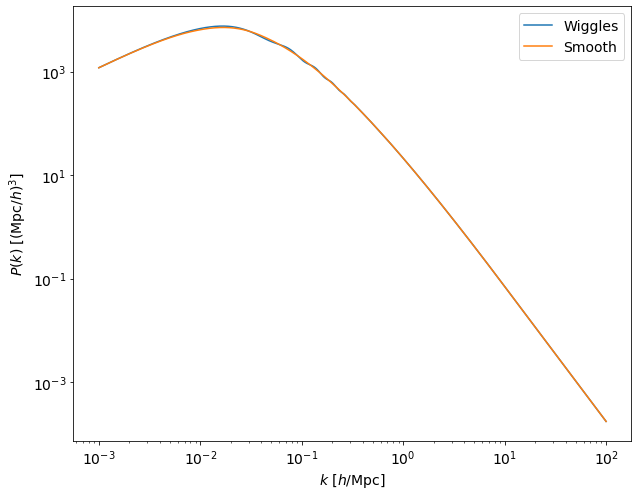

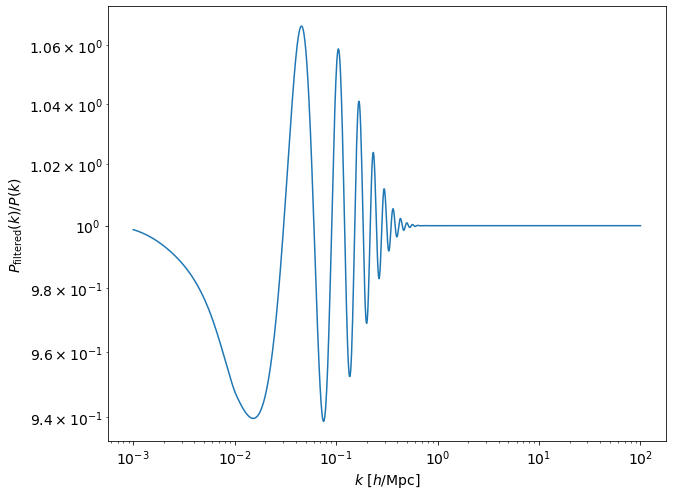

In [10]:
# Whether to include non linear effects
nonlinear = False
nonlinear_string = ''
if nonlinear:
    nonlinear_string = '_nonlinear'

fo = Fourier(cosmo_abacus, engine='camb')
pk = fo.pk_interpolator(nonlinear = nonlinear, extrap_kmin=1e-10, extrap_kmax=1e4).to_1d(z=z)

# BAO filter: extract smoothed power spectrum
pk_smooth = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()

k = np.logspace(-3,2,1000)

plt.loglog(k, pk(k), label='Wiggles')
plt.loglog(k, pk_smooth(k), label='Smooth')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

plt.loglog(k, pk_smooth(k)/pk(k))
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P_{\mathrm{filtered}}(k)/P(k)$')
plt.show()

## Model

[000001.41]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000001.42]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000001.50]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000001.50]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


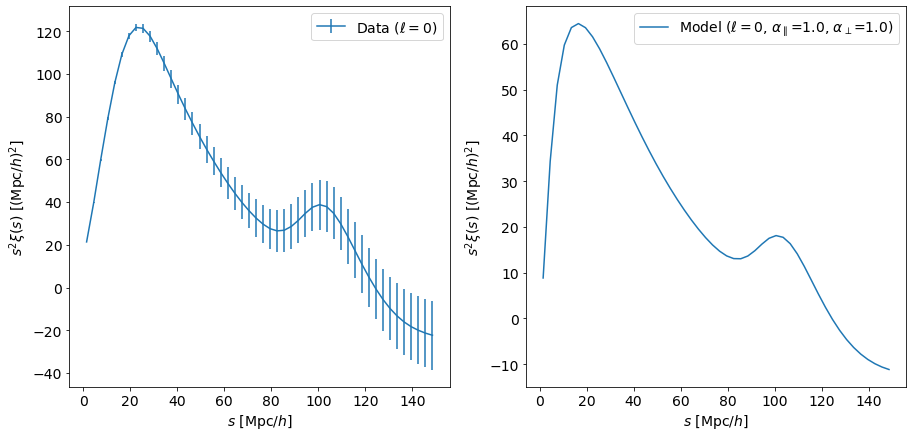

In [11]:
b = 2.
alpha_par = 1.
alpha_perp = 1.

pk_model = pk_model_poles(k, pk_smooth, pk, ells, f, b, alpha_par=alpha_par, alpha_perp=alpha_perp, sigma_par=20)

# Transform power spectrum model to correlation function model
xi_model = xi_model_poles_interp(k, pk_model, ells)

plt.rcParams["figure.figsize"] = (15, 7)
fig, axes = plt.subplots(1, 2)
                 
for ill,ell in enumerate(ells):
    axes[0].errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data ($\ell = {:d}$)'.format(ell))
    axes[0].legend()
    axes[0].set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
    axes[0].set_ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    
    axes[1].plot(s, s**2 * xi_model[ill](s), label = r'Model ($\ell = {:d}$, '.format(ell)+r'$\alpha_{\parallel}$'+'={:.1f}, '.format(alpha_par) + r'$\alpha_{\perp}$'+'={:.1f})'.format(alpha_perp))
    axes[1].set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
    axes[1].set_ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    axes[1].legend()

plt.show()

plt.rcParams["figure.figsize"] = (10, 8)

In [12]:
def broadband(s, coeffs):
    res = coeffs[0] * s**(-2) + coeffs[1] * s**(-1) + coeffs[2]
    return res

def dil_broadband_fitting_func(s, *args, sigma_par=20, **kwargs):
    b = args[0]
    broadband_coeffs = args[1:1+nells*3]
    alpha_par = args[nells*3+1]
    alpha_perp = None
    if nells > 1:
        alpha_perp = args[nells*3+2]
    
    pk_model = pk_model_poles(k, pk_smooth, pk, ells, f, b, alpha_par=alpha_par, alpha_perp=alpha_perp, sigma_par=sigma_par, **kwargs)
    
    xi_model = xi_model_poles_interp(k, pk_model, ells)
    
    broadbands = np.concatenate([broadband(s, broadband_coeffs[3*ill:3*(ill+1)]) for ill in range(len(ells))])
    xi_model_poles = np.concatenate([xi_model[ill](s) for ill in range(len(ells))])
    
    return broadbands + xi_model_poles

# Same as above but adding a polynomial broadband
def broadband_fitting_func(s, b, *broadband_coeffs, sigma_par=20):
    return dil_broadband_fitting_func(s, b, *broadband_coeffs, 1., 1., sigma_par=sigma_par)

In [13]:
# Remove small scales (linear model not valid at small scales)
lower_s_limit = 50 # Mpc/h
s_truncated = s[s>lower_s_limit]

xiell_truncated_list = list()
cov_list = list()
cov_truncated_list = list()
ns = len(s)

for ill, ell in enumerate(ells):
    xiell_truncated_list.append(xiell[ill][s>lower_s_limit])
    first_index = np.sum(np.logical_not(s>lower_s_limit))
    cov_ell = cov[ill*ns:(ill+1)*ns,ill*ns:(ill+1)*ns]
    cov_list.append(cov_ell)
    cov_truncated_list.append(cov_ell[first_index:, first_index:])
    
xiell_truncated = np.array(xiell_truncated_list)
cov_truncated = np.array(cov_truncated_list)

In [14]:
# Truncate the whole covariance matrix
ns_trunc = len(s_truncated)
cov_truncated_full = np.zeros((ns_trunc*nells, ns_trunc*nells))

for i in range(nells):
    for j in range(nells):
        cov_truncated_full[i*ns_trunc:(i+1)*ns_trunc,j*ns_trunc:(j+1)*ns_trunc] = cov[(i+1)*ns-ns_trunc:(i+1)*ns,(j+1)*ns-ns_trunc:(j+1)*ns]

## Fit model to data

### Bias + damping + broadband + dilatation parameters

In [15]:
# initialize parameters
p2_init = np.concatenate(([1.], np.tile([0., 0., 0.], nells)))

if nells == 1:
    p2_init = np.concatenate((p2_init, [1.]))
else:
    p2_init = np.concatenate((p2_init, [1., 1]))

t1 = time.time()
p2opt, p2cov = scipy.optimize.curve_fit(dil_broadband_fitting_func, s_truncated, xiell_truncated.flatten(), sigma = cov_truncated_full, p0=p2_init)
t2 = time.time()

print('Execution time: {:.2f}'.format(t2-t1))

print('Optimal parameters:')
print(p2opt)

print('Covariance matrix:')
print(p2cov)

print('Sigmas:')
print(np.diag(p2cov)**0.5)

Execution time: 1.44
Optimal parameters:
[ 3.05544622e+00  3.93860874e+00 -9.53503544e-02  5.23054170e-04
  1.00400071e+00]
Covariance matrix:
[[ 2.27463951e-04 -2.29127382e-02  3.02931834e-04 -9.05439399e-07
  -1.51709684e-07]
 [-2.29127382e-02  3.62217137e+00 -6.43679497e-02  2.65124978e-04
   1.61170258e-04]
 [ 3.02931834e-04 -6.43679497e-02  1.38910582e-03 -6.55177943e-06
  -5.63012084e-07]
 [-9.05439399e-07  2.65124978e-04 -6.55177943e-06  3.44114189e-08
  -3.28491886e-09]
 [-1.51709684e-07  1.61170258e-04 -5.63012084e-07 -3.28491886e-09
   4.91842246e-07]]
Sigmas:
[1.50819081e-02 1.90320030e+00 3.72707100e-02 1.85503151e-04
 7.01314655e-04]


In [16]:
model_broadband_dil = dil_broadband_fitting_func(s, *p2opt)

### Compute $\chi^2$

In [17]:
def compute_chisq(xdata, ydata, sigma, fitted_model):
    r = ydata - fitted_model
    
    chisq = r.T @ np.linalg.inv(sigma) @ r
    
    return chisq

In [18]:
chisq_AP_list = list()

for ill,ell in enumerate(ells):
    chisq_AP = compute_chisq(s_truncated, xiell_truncated[ill], cov_truncated[ill], model_broadband_dil[ill*ns:(ill+1)*ns][s>lower_s_limit])
    chisq_AP_list.append(chisq_AP)

    print("Chi square per degree of freedom :")
    print('l = {}'.format(ells[ill]))
    if nells > 1:
        print("Mdel with A&P effect: {:.2f}".format(chisq_AP/(ns_trunc-(1+3*nells+2))))
    else:
        print("Mdel with A&P effect: {:.2f}".format(chisq_AP/(ns_trunc-(1+3*nells+1))))

Chi square per degree of freedom :
l = 0
Mdel with A&P effect: 0.00


[000003.10]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000003.11]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000003.17]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000003.18]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


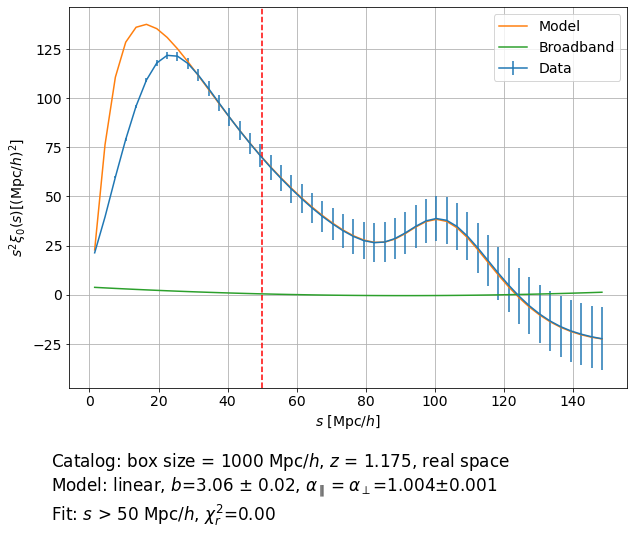

In [19]:
rsd_info = 'real space'
#if rsd:
#    rsd_info = 'redshift space'

linear_info = 'linear'    
if nonlinear:
    linear_info = 'non linear'

plt.rcParams["figure.figsize"] = (20, 7)

if nells > 1:
    fig, axes = plt.subplots(1, nells)

    for ill, ell in enumerate(ells):
        axes[ill].errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data')
        axes[ill].plot(s, s**2 * model_broadband_dil[ill*ns:(ill+1)*ns], label = 'Model')
        axes[ill].plot(s, s**2 * broadband(s, p2opt[1+3*ill:1+3*(ill+1)]), label = 'Broadband')
        axes[ill].axvline(lower_s_limit, linestyle='dashed', color='r')
        axes[ill].grid(True)
        axes[ill].legend()    
        axes[ill].set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
        axes[ill].set_ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')

    fig.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, '.format(catalog.boxsize, z) + rsd_info 
                 + '\n' + 'Model: ' + linear_info + ', $b$={:.2f} $\pm$ {:.2f}, '.format(p2opt[0], np.diag(p2cov)[0]**0.5)+r'$\alpha_{\parallel}$'+'={:.3f}'.format(p2opt[1+3*nells]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells]**0.5) + r', $\alpha_{\perp}$'+'={:.3f}'.format(p2opt[1+3*nells+1]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells+1]**0.5)
                 + '\n'  'Fit: $s$ > {:.0f} Mpc/$h$, '.format(lower_s_limit) + r'$\chi^2_{r}$=' +'{:.2f}'.format(chisq_AP_list[ill]/(ns_trunc-(1+3*nells+2))), 
                 ha='left', x=0.1, y=0)
    plt.show()

else:
    plt.rcParams["figure.figsize"] = (10, 7)

    ill = 0
    plt.errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data')
    plt.plot(s, s**2 * model_broadband_dil[ill*ns:(ill+1)*ns], label = r'Model')
    plt.plot(s, s**2 * broadband(s, p2opt[1+3*ill:1+3*(ill+1)]), label = 'Broadband')
    plt.axvline(lower_s_limit, linestyle='dashed', color='r')
    plt.grid(True)
    plt.legend()    
    plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
    plt.ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')

    plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, '.format(catalog.boxsize, z) + rsd_info 
                 + '\n' + 'Model: ' + linear_info + ', $b$={:.2f} $\pm$ {:.2f}, '.format(p2opt[0], np.diag(p2cov)[0]**0.5)+r'$\alpha_{\parallel}=\alpha_{\perp}$'+'={:.3f}'.format(p2opt[1+3*nells]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells]**0.5)
                 #+ ', $\Sigma_{\parallel}$='+'{:.3f}'.format(np.diag(p2cov)[2+3*nells]**0.5)
                 + '\n'  'Fit: $s$ > {:.0f} Mpc/$h$, '.format(lower_s_limit) + r'$\chi^2_{r}$=' +'{:.2f}'.format(chisq_AP_list[ill]/(ns_trunc-(1+3*nells+1))), 
                 ha='left', x=0.1, y=0)
    plt.show()
    

## With 2PCF fit

In [20]:
output_name = '/feynman/work/dphp/mp270220/outputs/AbacusSummit_highbase_c000_ph100_z1.175_corrfunc_randomx6_poles0_smin50'

popt_2PCF = np.load(output_name+'_AP_fit_popt.npy')
pcov_2PCF = np.load(output_name+'_AP_fit_pcov.npy')

model_2PCF = dil_broadband_fitting_func(s, *popt_2PCF, sigma_par=8)

[000003.30]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000003.30]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000003.36]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000003.37]  05-03 11:48  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


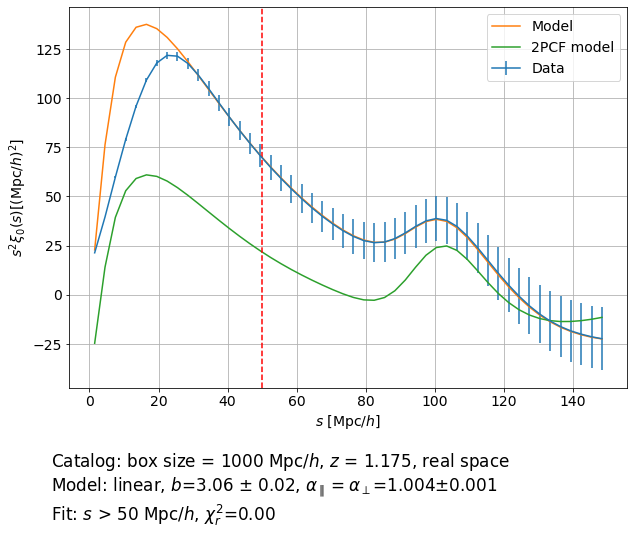

In [21]:
rsd_info = 'real space'
#if rsd:
#    rsd_info = 'redshift space'

linear_info = 'linear'    
if nonlinear:
    linear_info = 'non linear'

plt.rcParams["figure.figsize"] = (20, 7)

if nells > 1:
    fig, axes = plt.subplots(1, nells)

    for ill, ell in enumerate(ells):
        axes[ill].errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data')
        axes[ill].plot(s, s**2 * model_broadband_dil[ill*ns:(ill+1)*ns], label = 'Model')
        axes[ill].plot(s, s**2 * model_2PCF[ill*ns:(ill+1)*ns], label = '2PCF model')
        axes[ill].axvline(lower_s_limit, linestyle='dashed', color='r')
        axes[ill].grid(True)
        axes[ill].legend()    
        axes[ill].set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
        axes[ill].set_ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')

    fig.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, '.format(catalog.boxsize, z) + rsd_info 
                 + '\n' + 'Model: ' + linear_info + ', $b$={:.2f} $\pm$ {:.2f}, '.format(p2opt[0], np.diag(p2cov)[0]**0.5)+r'$\alpha_{\parallel}$'+'={:.3f}'.format(p2opt[1+3*nells]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells]**0.5) + r', $\alpha_{\perp}$'+'={:.3f}'.format(p2opt[1+3*nells+1]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells+1]**0.5)
                 + '\n'  'Fit: $s$ > {:.0f} Mpc/$h$, '.format(lower_s_limit) + r'$\chi^2_{r}$=' +'{:.2f}'.format(chisq_AP_list[ill]/(ns_trunc-(1+3*nells+2))), 
                 ha='left', x=0.1, y=0)
    plt.show()

else:
    plt.rcParams["figure.figsize"] = (10, 7)

    ill = 0
    plt.errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data')
    plt.plot(s, s**2 * model_broadband_dil[ill*ns:(ill+1)*ns], label = r'Model')
    plt.plot(s, s**2 * model_2PCF, label = '2PCF model')
    plt.axvline(lower_s_limit, linestyle='dashed', color='r')
    plt.grid(True)
    plt.legend()    
    plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
    plt.ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')

    plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, '.format(catalog.boxsize, z) + rsd_info 
                 + '\n' + 'Model: ' + linear_info + ', $b$={:.2f} $\pm$ {:.2f}, '.format(p2opt[0], np.diag(p2cov)[0]**0.5)+r'$\alpha_{\parallel}=\alpha_{\perp}$'+'={:.3f}'.format(p2opt[1+3*nells]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells]**0.5)
                 #+ ', $\Sigma_{\parallel}$='+'{:.3f}'.format(np.diag(p2cov)[2+3*nells]**0.5)
                 + '\n'  'Fit: $s$ > {:.0f} Mpc/$h$, '.format(lower_s_limit) + r'$\chi^2_{r}$=' +'{:.2f}'.format(chisq_AP_list[ill]/(ns_trunc-(1+3*nells+1))), 
                 ha='left', x=0.1, y=0)
    plt.show()
    